In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np

## Make sure Python 3.7 or above is used
import sys
assert sys.version_info >= (3, 7)

## Make sure Sklearn 1.0.1 or above is used
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Needed for importing the data
from pathlib import Path
import pandas as pd

#for graph creation
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from sklearn.datasets import fetch_openml

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier



# Classification

## Data: MNIST

Many popular datasets can be imported using sklearn. Sklearn has three type of data functions:
- fetch_* like fetch_openml() to download real-life data sets
- load_* for load (not download) toy datsets bundled in Sklearn
- make_* to create fake datasets that can be useful for tests

Generated data sets usuallu returns as a tuple (X,y) bith as numpy arrays. Other datasets are sklearn.util.Bunch class. These dictionaries can be accessed by the following variables:
- DESCR: description of dataset
- data: inout data as 2D Numpy Array
- tagert: labels as 1D Numpy Array

In [2]:
#fetching the MNIST dataset
mnist = fetch_openml("mnist_784", as_frame=False)
type(mnist)

sklearn.utils._bunch.Bunch

In [3]:
X, y = mnist.data, mnist.target
print(X)
print(X.shape)
print(y)
print(y.shape)
mnist.keys()  # extra code – we only use data and target in this notebook

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(70000, 784)
['5' '0' '4' ... '4' '5' '6']
(70000,)


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- There are 70,000 images each 28x28 pixels (784 columns). Each entry is one pixel's intesity

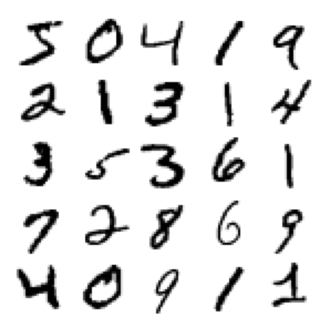

In [4]:
def plot_digit(image_data):
    image = image_data.reshape(28,28) #reshaping the row into a 28x28 image
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plt.figure(figsize=(4, 4))
for idx, image_data in enumerate(X[:25]):
    plt.subplot(5, 5, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [5]:
# This data is already shuffled. we can create the training and test datasets

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier

- Now we train a binary classifier which is only capable of detecting one number, e.g., 5 (5-detector).

In [6]:
#creating the target training set for the binary classifier

y_train_5 = (y_train=="5") # True if number is 5 and False if not
y_train_5

array([ True, False, False, ...,  True, False, False])

In [7]:
#creating the target test set for the binary classifier

y_test_5 = (y_test=="5") # True if number is 5 and False if not
y_test_5

array([False, False, False, ..., False,  True, False])

- Now we train a stochastic gradient descent classifier. This is useful for taking care of large database:

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #creating instance
sgd_clf.fit(X_train, y_train_5) #fitting the classier to training data

SGDClassifier(random_state=42)

In [9]:
print(sgd_clf.predict([X_train[11]]), y_train[11])
print(sgd_clf.predict([X_train[2]]), y_train[2])

[ True] 5
[False] 4


## Perforemance Measures

### Measuring Accuracy Using Cross-Validation

Using a k-fold cross_val_score() to evaluate our SGDClassifier.

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- It shows that this model is about 95% accurate. But how reliable are this result? Let's try a dummyclassifier (classifies everything in the most frequent class which is False in this case)

In [11]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) #print False: no 5s detected

False


In [12]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

- The accuracy is 90%. But this is because only 10% of the dataset is 5s. So even if it does not detect any 5s, it will be 90% accurate. That's why accuracy is not a good perforemance measure for classifiers specially if the dataset is skewed. A better measure is the Confusion Matrxi.

In [13]:
#for flexibility we can create the cross-validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


### Confusion Matrix

- The general idea is to count the number of times that instances of class A are classified as class B for all A/B pairs. For example to see how many times the classifier confused images of 8's with 0's we need to take a look at row #8 and column #0.

- To compute the confusion matrix, first we can use cross_val_predict. It is the same as corss_val_score, but it return a prediction of the dataset over k-folds.

- then we can calculate the confusion matrix using confusion_matrix()

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) #creating a predictio of the training set

In [15]:
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

- in the above result, 53892 of non 5s were correctly classified, and 687 were classified as 5s. 1891 5s were classified as non 5s and 3530 were classified correclty.

### Precision and Recall
One good measure is accuracy of of the positive predictions:

$$\text{precision}=\frac{\text{TP}}{\text{TP}+\text{FP}}$$

where $\text{TP}$ is number of True Positibes and $\text{FP}$ is the number of False Positives.
This measure does not consider False negatives, so a better measure is called recall, or sensitivity or TPR (true Positive rate):

$$\text{recall}=\frac{\text{TP}}{\text{TP}+\text{FN}}$$

where $\text{FN}$ is False Negatives. This shows the percentage of correct detections.

In [16]:
from sklearn.metrics import precision_score, recall_score

print(f'Precision: {precision_score(y_train_5, y_train_pred)}')
print(f'Recall: {recall_score(y_train_5, y_train_pred)}')

Precision: 0.8370879772350012
Recall: 0.6511713705958311


- The classifier is only correct 83% of the time
- Can only detect 65% of the 5s

If we want to use both in one metric, we can use the $F_1$ score. It is the harmanic mean of recall and precision. 

$$F_1=\frac{TP}{TP+\frac{FN+FP}{2}}$$

$F_1$ score usually favors the classifiers with similar recall and precision. But in some context we care about precision and in some others the recall.

- High precision: When we want less False positives (when you want to be precise in your detection and have less non5s be detected as 5)
- High recall: When we want less False negative (when you want to detect most of the 5s but you are ok if a few non 5s are detected by mistake)

In [17]:
from sklearn.metrics import f1_score
print(f'Recall: {f1_score(y_train_5,y_train_pred)}')

Recall: 0.7325171197343846


### Precision/Recall Trade-Off

There is a trade-off between precision/recall. The SGD classifier uses a decision function and if a digit is above its threshold it is considered as detected and True. When we increase the precision by increasing the threshold, less false positives are detected, but some of the true positives are also missed (lower recall).

In [18]:
some_digit=X[0]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
#increasing the threshold
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#precision increased, recall reduced

array([False])

To find the threshold we first use the cross_val_predict() to get the score of all instances of the training set, using below. Then we use precision_recall_curve() to compute precision and recall for all possible thresholds.

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [22]:
len(y_scores)

60000

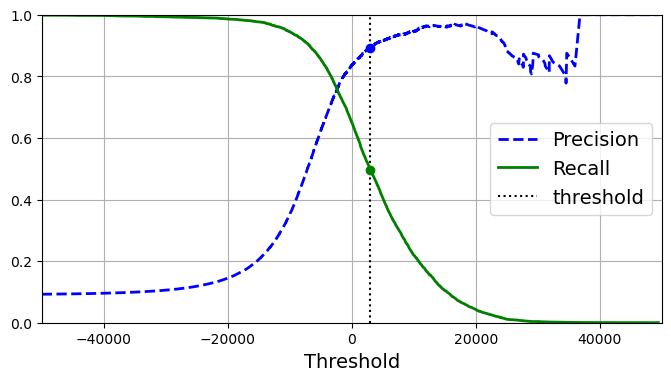

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

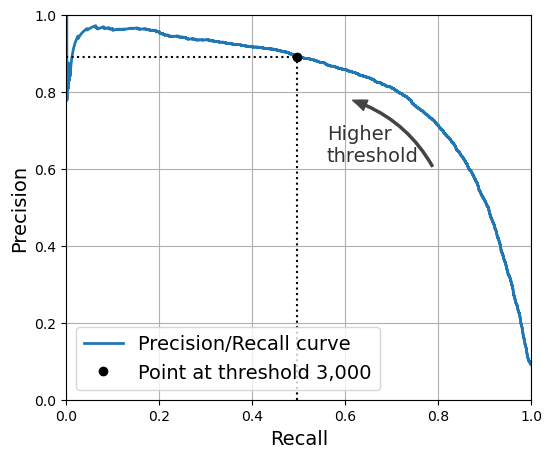

In [24]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

- A perfect classifer has the curve closer to the top right corner. So there is room for imporovement in this case.
- Suppose you want to to aim for 90%. We can use argmax(). Then make predictions instead of using predict we can use the following:

In [25]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [26]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

### The ROC Curve (Receiver Operating Characteristic)

Plots true positive rate (recall) vs. fasle positive rate (FPR or fall-out). FPR is ratio negative instances that are incorrectly classified as positive.
FPR is equal to 1 - True Negative rate (TNR or specificity) - true negative instances that are correctly classified as negative). 

ROC: recall vs FPR (fall-out) or sensitivity vs 1-specificty.

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

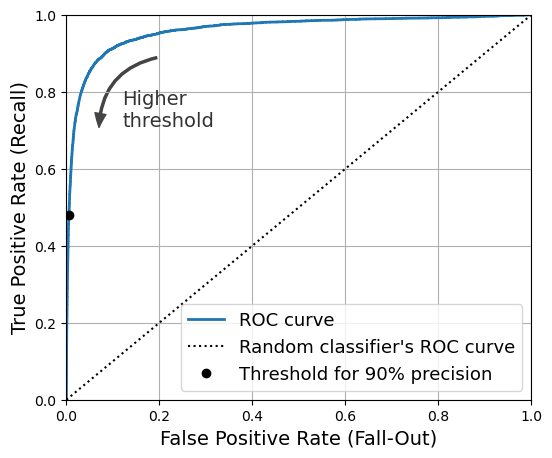

In [28]:
#finding the 90% threshold. the threshold is in a decreasing order
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

Again we can see a trade-off in ROC Curve. Higher Recall (TPR), the more FPR the classifier produces. A good classifier has the curve close as possible to the top left corner.

One way to compare the classifiers is to measure the area under the curve (AUC). A perfect classifier has an AUC=1.


In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### RandomForrestClassifier (Comparison to SGD_Class)

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
#this classifier does not have a decision function, but we can use the predict_proba value that returns class probabilities as a score
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [31]:
#looking at the probability of the fist two images
print(y_train[:2])
print(y_probas_forest[:2])
#the first image is 89% positive and the second image is 1% positive which is correct

['5' '0']
[[0.11 0.89]
 [0.99 0.01]]


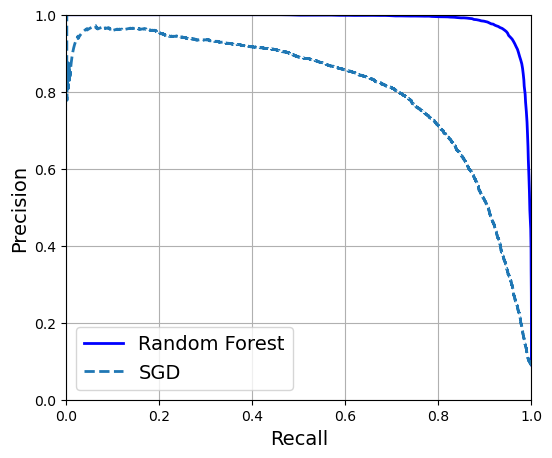

In [32]:
#we can pass the second column which shows the probablity of being in positive class to the PR curve

y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

In [33]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

- As it can be seen the randomforestclassifier has a much better perforemance comparing o SGDClass and it has better $F_1$ and AUC numbers too.

## Multiclass Classification

Multiclass or Multinomal classifiers distinguish between more than two classes.

- OVA or OVR: one-versus-All or One-versus-the-rest, we train 10 binary classifiers each classifying one digit. The overall classifier gets scores for each binary classifier and chooses the class with the highest score. 
- OVO: One-versus-One, we train classifiers that distinguisesh between each pair (e.g., 0 vs 2). If there are $N$ classes, we need to train $\frac{N(N-1)}{2}$ classifiers. It's like duels between the classes and we see which class wins at the end. The main advantage of OvO is that you pnly need to train each classifier on the set of images that has the two classes in it (not all dataset). For algorithms that scales poorly by the size of the dataset, OVO is preffered. But for the rest OvR is preferred.

Sklearn automatticaly detects which method you want to use depending on the algorithm.

#### OVO

In [35]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5
# this automatically runs OVO

SVC(random_state=42)

In [36]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [37]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

- This code actually made 45 predictions—one per pair of classes—and it selected the class that won the most duels. If you call the decision_function() method, you will see that it returns 10 scores per instance: one per class. Each class gets a score equal to the number of won duels

In [38]:
#The highest score is 9.3, and it’s indeed the one corresponding to class 5:
class_id = some_digit_scores.argmax()
class_id

5

In [39]:
# When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value.
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

### OVR

OneVsOneClassifier or OneVsRestClassifier classes can be used. Simply create an instance and pass a classifier to its constructor (it doesn’t even have to be a binary classifier).

In [40]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [41]:
print(ovr_clf.predict([some_digit])) #the prediicted class
print(len(ovr_clf.estimators_)) #number of trained classifiers is 10

['5']
10


In [42]:
## SGD Classifier for multiclass

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train[:2000], y_train[:2000])
sgd_clf.predict([some_digit]) #predicition is incorrect in this case

array(['5'], dtype='<U1')

In [43]:
#OVR is used and it has 10 classifiers and we can see the scores of each classifier
sgd_clf.decision_function([some_digit]).round()

array([[-1704540., -1683382., -2594123.,  -145668., -3270741.,    -4884.,
        -3420127., -1846510., -1328858., -2043246.]])

- You’ll want to evaluate this classifier on more than one image. Since there are roughly the same number of images in each class, the accuracy metric is fine. As usual, you can use the cross_val_score() function to evaluate the model:

In [44]:
cross_val_score(sgd_clf, X_train[:2000], y_train[:2000], cv=3, scoring="accuracy")

array([0.84857571, 0.80809595, 0.84084084])

It gets over 85.8% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89.1%:

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled[:2000], y_train[:2000], cv=3, scoring="accuracy")

array([0.84857571, 0.82008996, 0.85885886])

### Error Analysis

First, look at the confusion matrix. For this, you first need to make predictions using the cross_val_predict() function; then you can pass the labels and predictions to the confusion_matrix() function.

To plot such a diagram, use the ConfusionMatrixDisplay.from_predictions() function like this:

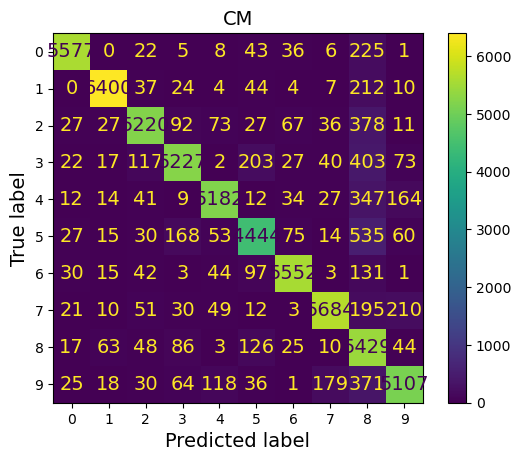

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("CM")
plt.show()

This confusion matrix looks pretty good: most images are on the main diagonal, which means that they were classified correctly. Notice that the cell on the diagonal in row #5 and column #5 looks slightly darker than the other digits. This could be because the model made more errors on 5s, or because there are fewer 5s in the dataset than the other digits. That’s why it’s important to normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class (i.e., divide by the row’s sum). This can be done simply by setting normalize="true". We can also specify the values_format=".0%" argument to show percentages with no decimals. 

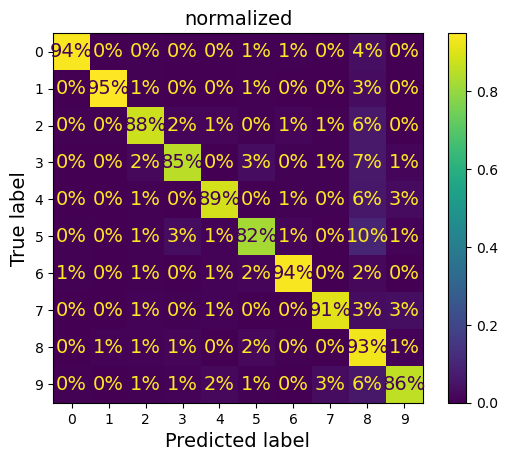

In [47]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.title("normalized")
plt.show()

- The most common error the model made with images of 5s was to misclassify them as 8s: this happened for 10% of all 5s. But only 2% of 8s got misclassified as 5s; confusion matrices are generally not symmetrical! 

- If you want to make the errors stand out more, you can try putting zero weight on the correct predictions.

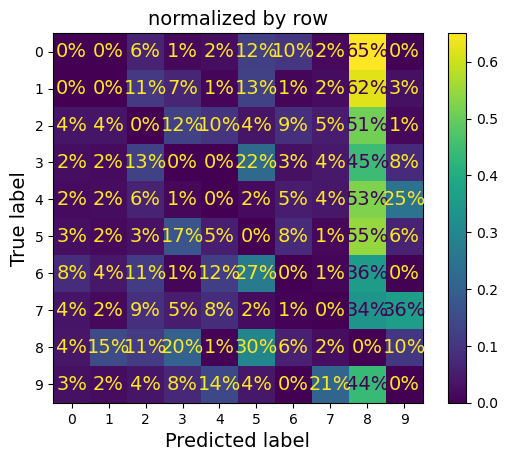

In [48]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.rc('font', size=10)
plt.title("normalized by row")
plt.show()

- It is also possible to normalize the confusion matrix by column rather than by row: if you set normalize="pred"

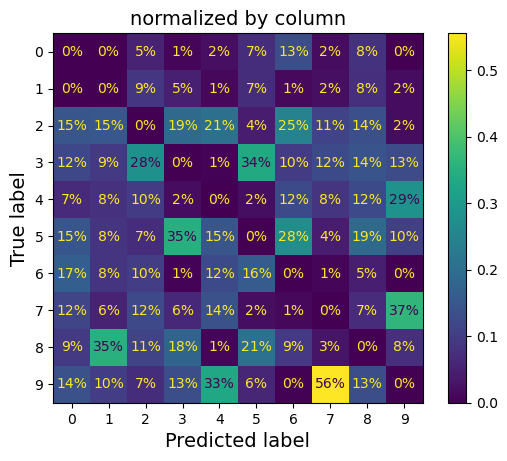

In [49]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
plt.title("normalized by column")
plt.show()

- Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at these plots, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

## Multilabel Classification

- Until now, each instance has always been assigned to just one class. But in some cases you may want your classifier to output multiple classes for each instance.

- Say the classifier has been trained to recognize three faces: Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [True, False, True] (meaning “Alice yes, Bob no, Charlie yes”).

In [50]:
'''
This code creates a y_multilabel array containing two target labels for each digit image:
the first indicates whether or not the digit is large (7, 8, or 9), and the second indicates whether or not it is odd.
Then the code creates a KNeighborsClassifier instance, which supports multilabel classification (not all classifiers do),
and trains this model using the multiple targets array. 
'''

import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] ##create a multilablel tagrte for MNIST dataset
 
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [51]:
knn_clf.predict([some_digit])

array([[False,  True]])

### Perforemance Evaluation

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score.

In [52]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- This approach assumes that all labels are equally important. 

- To set the importance of each label, one simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" when calling the f1_score() function.⁠

- If you wish to use a classifier that does not natively support multilabel classification, such as SVC, one possible strategy is to train one model per label. However, this strategy may have a hard time capturing the dependencies between the labels. To solve this issue, the models can be organized in a chain: when a model makes a prediction, it uses the input features plus all the predictions of the models that come before it in the chain.

The good news is that Scikit-Learn has a class called ChainClassifier that does just that! By default it will use the true labels for training, feeding each model the appropriate labels depending on their position in the chain. But if you set the cv hyperparameter, it will use cross-validation to get “clean” (out-of-sample) predictions from each trained model for every instance in the training set, and these predictions will then be used to train all the models later in the chain.

In [53]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000],y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [54]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification

Also called multioutput–multiclass classification. It is a generalization of multilabel classification where each label can be multiclass (not binary).

### Noise Removal from Digits

- To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intensities.
- Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification.

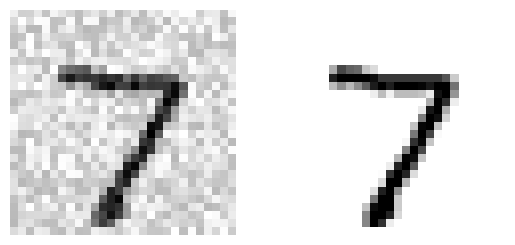

In [55]:
np.random.seed(42) # to make this code example reproducible
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise #creating noisy training set
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise #creating noisy test set
y_train_mod = X_train #creating new training target set
y_test_mod = X_test #creating new test target set
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

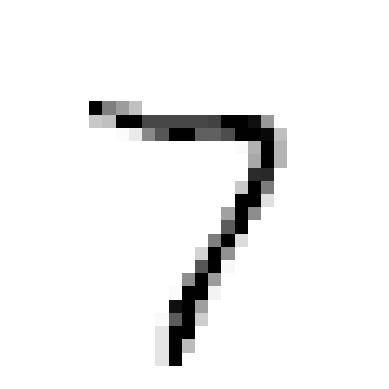

In [56]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)